# Time Series Analysis & Forecasting (Stock Prices)

In this task, we analyze and forecast **stock prices** using **time series methods**.  
Time series analysis is unique because **time order matters** — past values influence future values.

We’ll go through:
1. **Visualizing & decomposing** the series into **trend**, **seasonality**, and **residuals**.
2. Applying **smoothing techniques** (Moving Average & Exponential Smoothing).
3. Building an **ARIMA model** for forecasting.
4. Evaluating with **RMSE** (Root Mean Squared Error).
5. **Visualizing the forecast** vs actual data.


## Step 1: Load & Explore Stock Price Data

We’ll use daily stock prices for a company (e.g., **Apple - AAPL**).  
The data typically includes:
- **Date**: Trading date.
- **Open, High, Low, Close**: Price points.
- **Volume**: Number of shares traded.

**Why stock closing prices?**  
- Closing price reflects the final value after market activity and is most used for forecasting.

**Goal:** Forecast future stock prices using historical closing prices.

In [1]:
# Step 1: Load Stock Data
# We’ll use the yfinance library to fetch historical data.

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Load Apple stock data (last 5 years)
df = yf.download('AAPL', start='2018-01-01', end='2023-12-31')

# Keep only the 'Close' price
df = df[['Close']]

# View data
print(df.head())


/tmp/ipython-input-4114040088.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2018-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed

Price           Close
Ticker           AAPL
Date                 
2018-01-02  40.426819
2018-01-03  40.419788
2018-01-04  40.607533
2018-01-05  41.069859
2018-01-08  40.917313


## Step 2: Plot & Decompose the Series

Before modeling, we visualize the data:
- **Trend:** Is the stock generally going up or down?
- **Seasonality:** Are there repeating patterns (e.g., monthly, quarterly)?
- **Residuals (Noise):** Random variations not explained by trend or seasonality.

We use **seasonal decomposition**:
- **Additive model:** Data = Trend + Seasonality + Residual.
- **Multiplicative model:** Data = Trend × Seasonality × Residual (good for growth-like series).

This gives us insights into the underlying patterns.

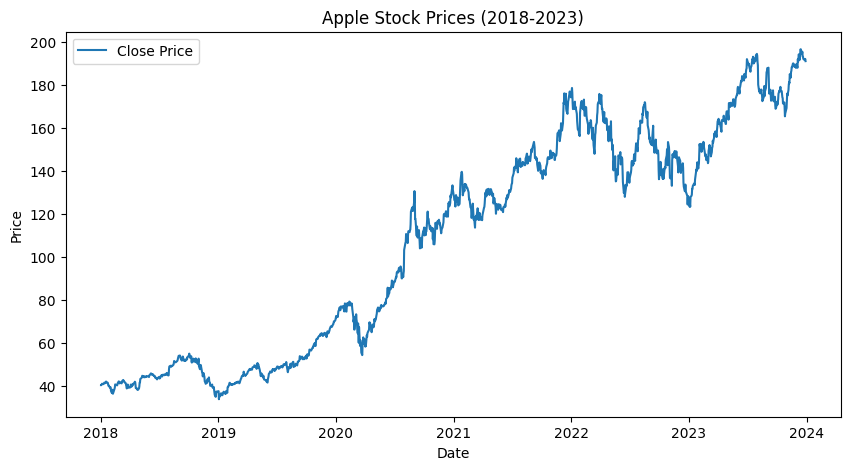

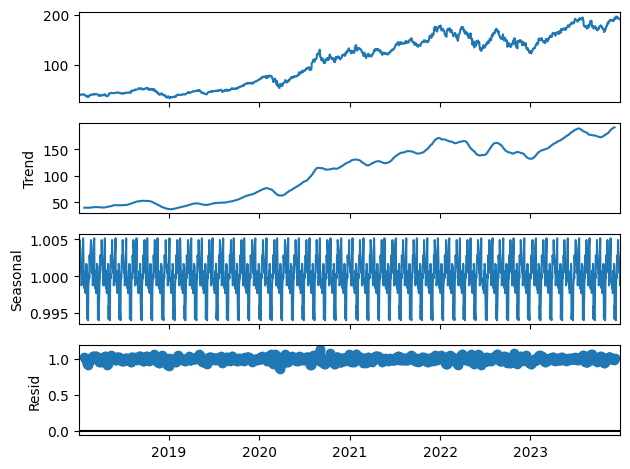

In [2]:
# Step 2: Plot & Decompose

from statsmodels.tsa.seasonal import seasonal_decompose

# Plot closing prices
plt.figure(figsize=(10,5))
plt.plot(df['Close'], label='Close Price')
plt.title("Apple Stock Prices (2018-2023)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Decompose (multiplicative)
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=30)
decomposition.plot()
plt.show()


## Step 3: Moving Average & Exponential Smoothing

### Moving Average:
- Smooths short-term fluctuations to highlight long-term trends.
- **Example:** A 30-day moving average shows a smoothed stock price, ignoring daily noise.

### Exponential Smoothing:
- Gives **more weight to recent observations**.
- Controlled by a parameter **α (alpha)**:
  - α close to 1 → reacts strongly to recent changes.
  - α close to 0 → smoother, slower response.

Why use smoothing?
- To remove noise and better capture the trend before forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


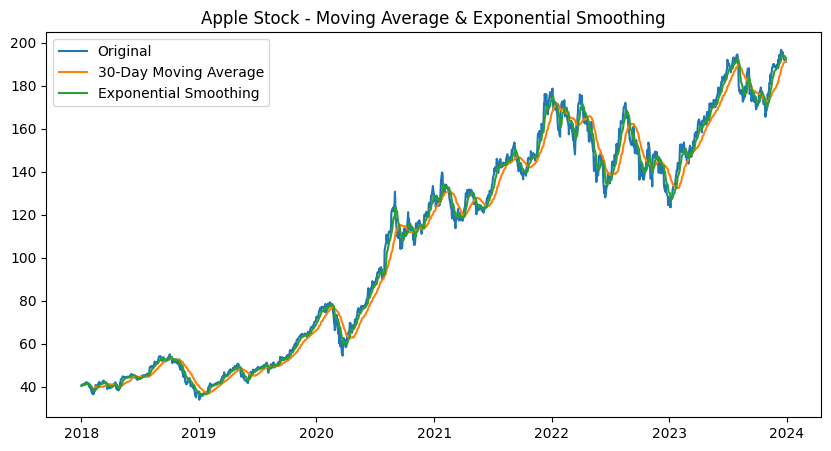

In [3]:
# Step 3: Moving Average & Exponential Smoothing

# Moving Average (30-day)
df['MA_30'] = df['Close'].rolling(window=30).mean()

# Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

exp_model = SimpleExpSmoothing(df['Close']).fit(smoothing_level=0.2, optimized=False)
df['Exp_Smooth'] = exp_model.fittedvalues

# Plot
plt.figure(figsize=(10,5))
plt.plot(df['Close'], label='Original')
plt.plot(df['MA_30'], label='30-Day Moving Average')
plt.plot(df['Exp_Smooth'], label='Exponential Smoothing')
plt.title("Apple Stock - Moving Average & Exponential Smoothing")
plt.legend()
plt.show()


## Step 4: Build ARIMA Model

### What is ARIMA?
ARIMA stands for:
- **AR (AutoRegressive):** Current value depends on past values.
- **I (Integrated):** Differencing the series to make it stationary (remove trends).
- **MA (Moving Average):** Current value depends on past forecast errors.

It has **3 parameters**:
- **p:** Number of autoregressive terms (past values).
- **d:** Degree of differencing (to remove trend).
- **q:** Number of moving average terms (past forecast errors).

**Example:** ARIMA(2,1,2):
- Looks at the previous 2 values,
- Applies 1 differencing step,
- Considers 2 past error terms.

We’ll:
- Split the data into **training** and **test** sets.
- Fit an ARIMA model on training data.
- Forecast on test data.

---

## Step 5: Evaluate the Model

We use **RMSE (Root Mean Squared Error)**:
$$
RMSE = \sqrt{\frac{\sum (y_{pred} - y_{actual})^2}{n}}
$$
- Lower RMSE = better forecast.

We’ll compare RMSE across different models (e.g., Moving Average vs ARIMA).

In [4]:
# Step 4: Build ARIMA Model

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Train-test split
train = df['Close'][:-60]
test = df['Close'][-60:]

# Fit ARIMA
model = ARIMA(train, order=(5,1,2))  # p,d,q (tuned manually)
fitted = model.fit()

# Forecast
forecast = fitted.forecast(steps=60)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"ARIMA RMSE: {rmse:.2f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

ARIMA RMSE: 14.80


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Step 6: Visualize the Forecast

Finally, we plot:
- **Training data** (historical stock prices).
- **Test data** (unseen actual prices).
- **Forecast** (predicted prices by our model).

This visual check tells us how well our model performs and whether it follows the stock's real movement.


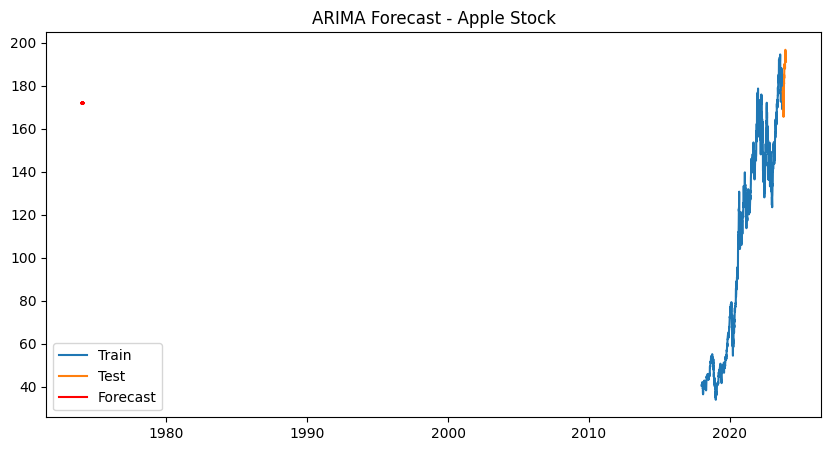

In [5]:
# Step 5: Visualize Forecast

plt.figure(figsize=(10,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(forecast, label="Forecast", color='red')
plt.title("ARIMA Forecast - Apple Stock")
plt.legend()
plt.show()


## Extensions (Optional)
- **SARIMA:** ARIMA with seasonality components — useful if the stock shows strong seasonal patterns.
- **Auto ARIMA:** Automatically selects the best p, d, q.
- **Prophet (by Meta):** A robust library for time series forecasting.

---

## Key Takeaways
- Stock price forecasting requires understanding **trends and noise**.
- **Smoothing** helps reveal underlying patterns.
- **ARIMA** is a powerful baseline model for time series forecasting.
- Visualizing predictions helps validate the model before real-world use.